<a href="https://www.kaggle.com/code/levimjoseph/titanic-classification?scriptVersionId=127622790" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Problem Understanding

The Titanic competition is a classification problem where we are tasked with predicting whether or not a passenger survived the ship's sinking.

**Goal:** place in top the 10% of rolling leaderboard.

In [70]:
# initial imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# set the random seed state for reproducibility
random_state = 42

In [71]:
# import train and test set
train_df = pd.read_csv('../input/titanic/train.csv')
test_df = pd.read_csv('../input/titanic/test.csv')

In [72]:
# confirm train_df
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [73]:
# confirm test_df
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [74]:
# get basic info on the train_df
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [75]:
# get basic info on the test_df
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


**Dimensions**

`Survived` is the dependent variable.

The training data has 891 rows and 11 columns. 

Our test data has 418 rows and 10 columns.

**Data Dictionary**

* `PassengerId` - int. Key.
* `Survived` - int. Survival. Boolean.
* `Pclass` - int. Ticket class.
* `Name` - str. Name of passenger.
* `Sex` - str. Sex of passenger.
* `Age` - float. Age of passenger. If age is estimated, takes xx.5. Has nulls.
* `SibSp` - int. # of siblings/spouses on board.
* `Parch` - int. # of parents/ children aboard the titanic.
* `Ticket` - str. Ticket number.
* `Fare` - float. Fare paid by passenger. Has nulls.
* `Cabin` - str. Cabin of passenger. Has nulls.
* `Embarked` - str. Port of embarkation. C = Cherbourg, Q = Queenstown, S = Southampton. Has nulls.

**Initial Hypotheses**

* Young children will survive.
* Young women will survive.
* Rich people will survive.
* Location on ship matters.
* Titles will or will not survive (depending on title).
* Larger families will not survive.

## Dependent Variable EDA

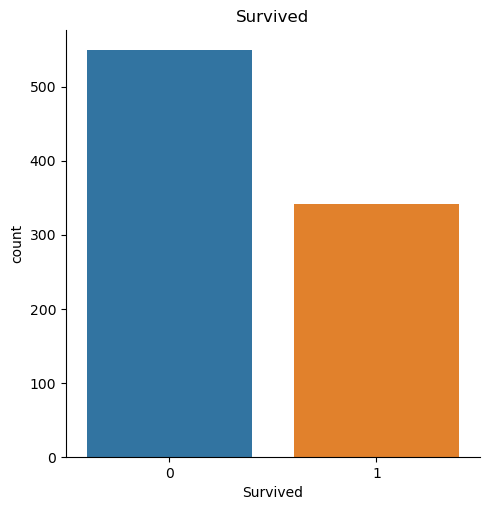

In [76]:
# Survived
sns.catplot(x='Survived', data=train_df, kind='count').set(title='Survived')
plt.show()

`Survived` is relatively balanced (62:38 split).

## Categorical EDA

### Pclass

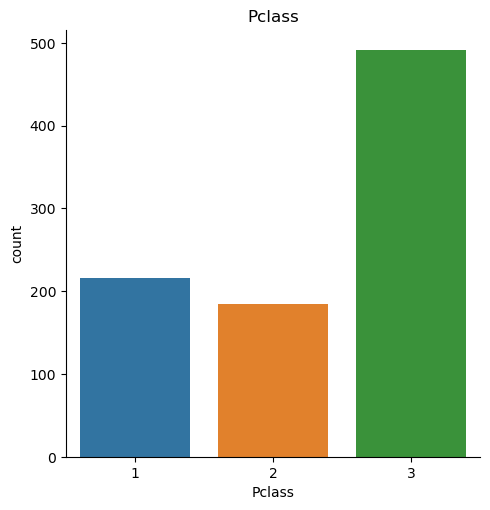

In [77]:
# PClass
sns.catplot(x='Pclass', data=train_df, kind='count').set(title='Pclass')
plt.show()

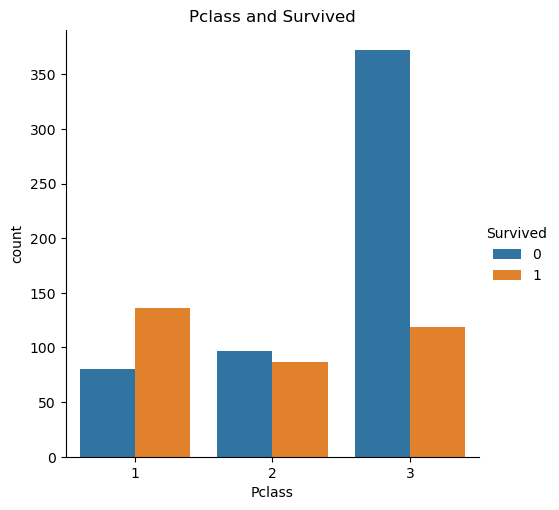

In [78]:
# PClass and Survived
sns.catplot(x='Pclass', hue='Survived', data=train_df, kind='count').set(title='Pclass and Survived')
plt.show()

As expected, `Pclass` appears to be correlated with survival.

### Sex

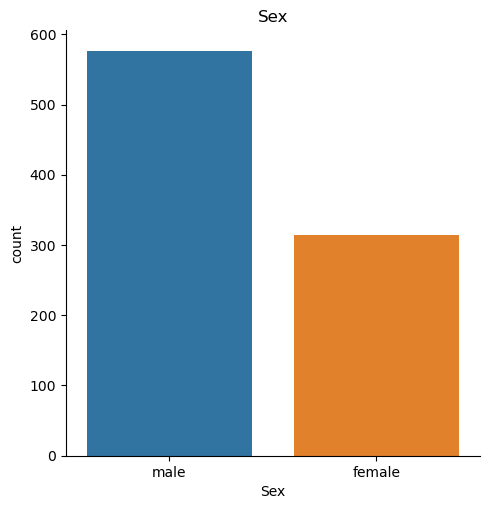

In [79]:
# Sex
sns.catplot(x='Sex', data=train_df, kind='count').set(title='Sex')
plt.show()

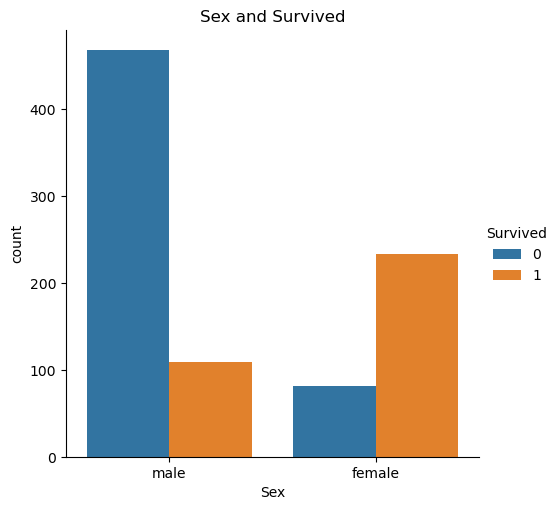

In [80]:
# Sex and Survived
sns.catplot(x='Sex', hue='Survived', data=train_df, kind='count').set(title='Sex and Survived')
plt.show()

`Sex` appears to be correlated with survival.

### Embarked

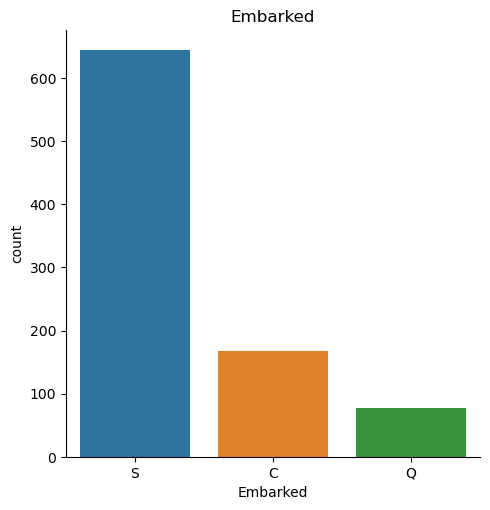

In [81]:
# Embarked
sns.catplot(x='Embarked', data=train_df, kind='count').set(title='Embarked')
plt.show()

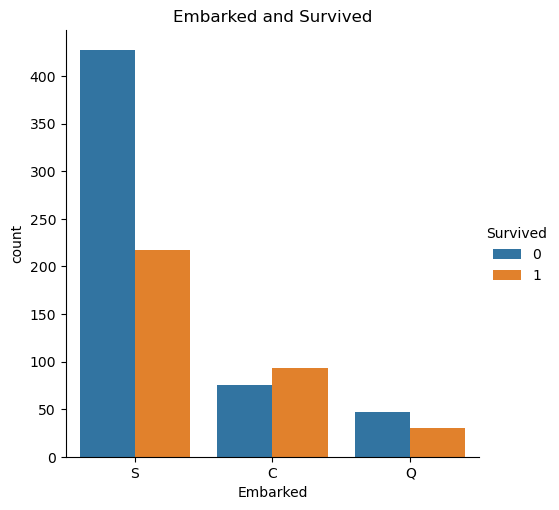

In [82]:
# Embarked and Survived
sns.catplot(x='Embarked', hue='Survived', data=train_df, kind='count').set(title='Embarked and Survived')
plt.show()

`Embarked` appears to be correlated with survival. However,`Embarked` may be correlated with `Pclass` (given the nature of English economic geography at this time).

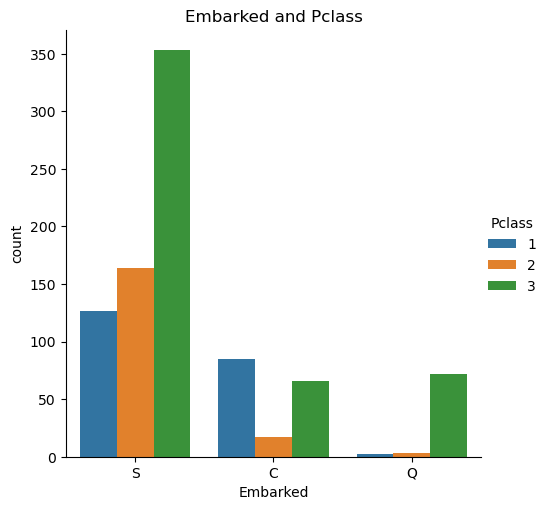

In [83]:
# Embarked and Pclass
sns.catplot(x='Embarked', hue='Pclass', data=train_df, kind='count').set(title='Embarked and Pclass')
plt.show()

S is disproportionately 3rd class. The relationship between `Embarked` appears to be a spurious correlation. `Pclass` is likely the underlying structure driving survival here.

## Quantitative EDA

In [84]:
# basic distributions of train_df
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [85]:
# basic distributions of test_df
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


### Age

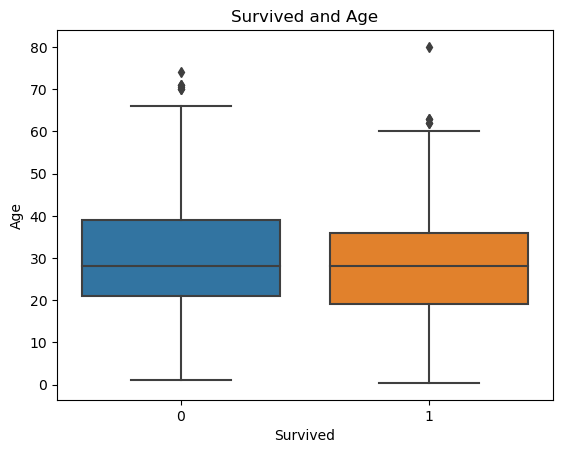

In [86]:
# Survived and Age
sns.boxplot(x='Survived', y='Age', data=train_df).set(title='Survived and Age')
plt.show()

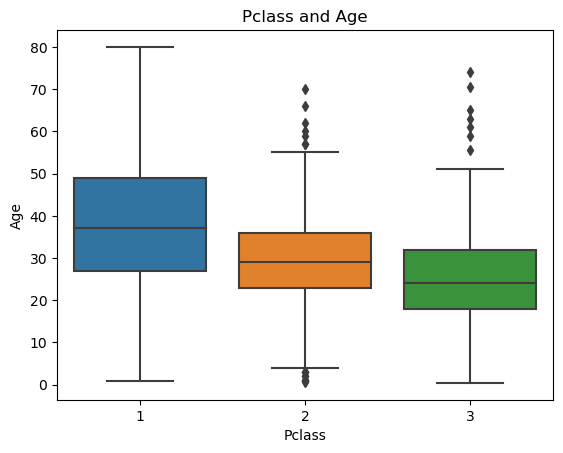

In [87]:
# Pclass and Age
sns.boxplot(x='Pclass', y='Age', data=train_df).set(title='Pclass and Age')
plt.show()

1st class is older than second class which is older than 3rd class on average. Second class has fewer children.

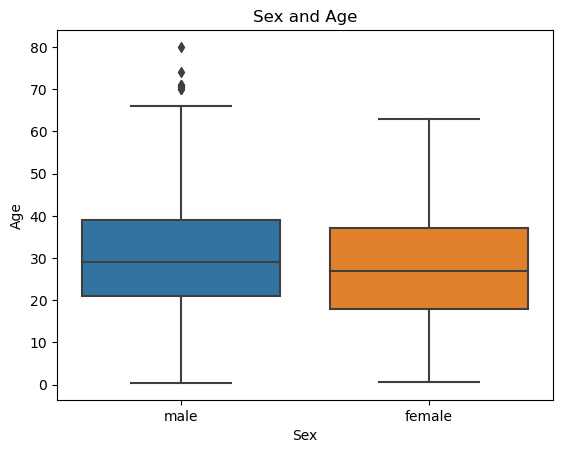

In [88]:
# Sex and Age
sns.boxplot(x='Sex', y='Age', data=train_df).set(title='Sex and Age')
plt.show()

Men were slightly older in general and had all the elderly individuals.

---
# Data Preparation

In [89]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [90]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


## Null Imputation

**Categorical columns with nulls**

* `Cabin` (train and test)
* `Embarked` (train)

**Numerical columns with nulls**

* `Age` (train and test)
* `Fare` (test)


In [92]:
# Cabin impute
train_df['Cabin'] = train_df['Cabin'].fillna('NA') 
test_df['Cabin'] = test_df['Cabin'].fillna('NA') 

In [93]:
# Embarked impute using mode
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])

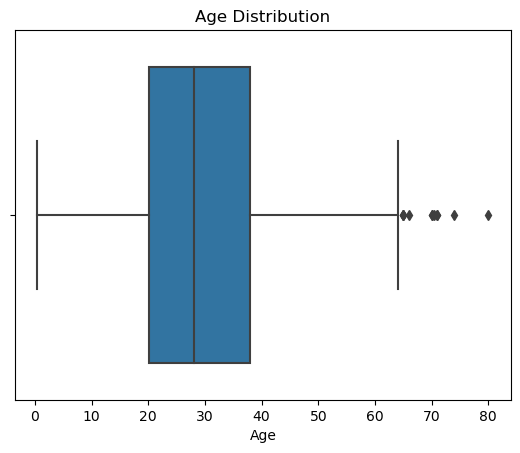

In [94]:
# checking Age for distribution and outliers
sns.boxplot(x='Age', data=train_df).set(title='Age Distribution')
plt.show()

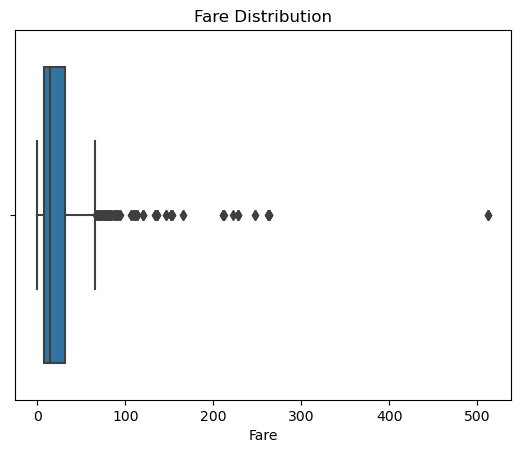

In [95]:
# checking Fare for distribution and outliers
sns.boxplot(x='Fare', data=train_df).set(title='Fare Distribution')
plt.show()

It appears that `Age` is relatively symmetrical and that `Fare` is right skewed. I will use mean imputation for `Age` and median imputation for `Fare`.

In [96]:
# Age impute
train_age_mean = train_df['Age'].mean()

train_df['Age'] = train_df['Age'].fillna(train_age_mean)

test_df['Age'] = test_df['Age'].fillna(train_age_mean)

In [97]:
# Fare impute
train_fare_median = train_df['Fare'].median()

test_df['Fare'] = test_df['Fare'].fillna(train_fare_median)

*Note*: I use attributes from the train dataset in order to impute for the test dataset.

In [98]:
# confirm the imputation worked
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [99]:
# confirm the imputation worked
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        418 non-null    object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


It appears that there are no more null values in either dataset.

## Feature Engineering

### Age Bucket

Bucket `Age` into 'child, 'adult', and 'elderly'

In [45]:
# age_bucket
age_bins = [0, 18, 65, 100]
age_labels = ['child','adult', 'elderly']

train_df['age_bucket'] = pd.cut(x=train_df['Age'], bins=age_bins,labels=age_labels).astype('object')

test_df['age_bucket'] = pd.cut(x=test_df['Age'], bins=age_bins, labels=age_labels).astype('object')

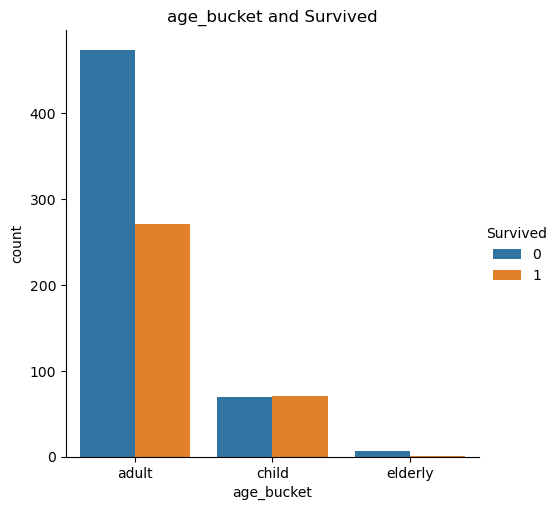

In [48]:
# ship_location and survived
sns.catplot(x='age_bucket', hue='Survived', data=train_df, kind='count').set(title='age_bucket and Survived')
plt.show()

Being either a child or elderly appears to improve survival rate.

### Role

I noticed in examining the data that certain names have titles (Mr, Ms, Don, Capt, etc.) and I want to bucket these into roles.

In [49]:
# extract titles
train_df[['last_name','intermediate']] = train_df['Name'].str.split(', ', expand=True)
train_df[['title','first_name']] = train_df['intermediate'].str.split('.', 1, expand=True)
train_df = train_df.drop(columns=['last_name', 'intermediate', 'first_name'])

test_df[['last_name','intermediate']] = test_df['Name'].str.split(', ', expand=True)
test_df[['title','first_name']] = test_df['intermediate'].str.split('.', 1, expand=True)
test_df = test_df.drop(columns=['last_name', 'intermediate', 'first_name'])

In [50]:
# unique titles
train_title_set = set(train_df['title'].tolist())
test_title_set = set(test_df['title'].tolist())
title_sorted = sorted(train_title_set.union(test_title_set))

print(title_sorted)

['Capt', 'Col', 'Don', 'Dona', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master', 'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir', 'the Countess']


In [51]:
# assign titles to roles
def assign_role(row):
    if row['title'] in ['Capt', 'Col', 'Major']:
        return 'officer'
    elif row['title'] in ['Don', 'Dona', 'Dr', 'Jonkheer', 'Lady', 'Master', 'Rev', 'Sir', 'the Countess']:
        return 'important'
    elif row['title'] in ['Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms']:
        return 'average'
    
train_df['role'] = train_df.apply(lambda row: assign_role(row), axis=1)
test_df['role'] = test_df.apply(lambda row: assign_role(row), axis=1)

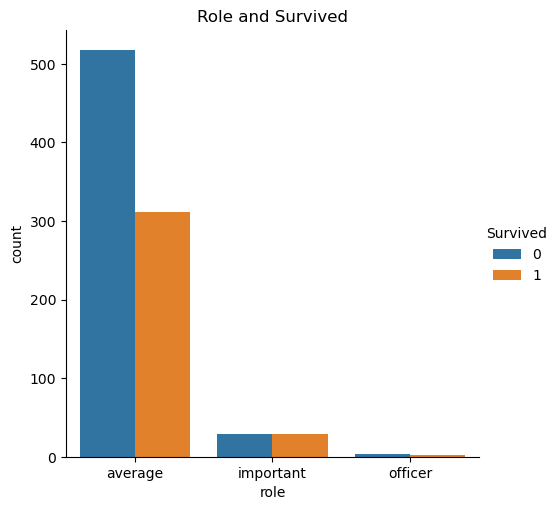

In [53]:
# role and survived
sns.catplot(x='role', hue='Survived', data=train_df, kind='count').set(title='Role and Survived')
plt.show()

Both "important" and "officer" roles appear to improve survival rate.


### Ship Location

Ship location may matter due to proximity to lifeboats and upper deck access.


In [100]:
# see if there is a connection between Ticket and Cabin
train_df[['Ticket', 'Cabin']].head(10)

,Ticket,Cabin
0,A/5 21171,NA
1,PC 17599,C85
2,STON/O2. 3101282,NA
3,113803,C123
4,373450,NA
5,330877,NA
6,17463,E46
7,349909,NA
8,347742,NA
9,237736,NA


Cabin itself is a high cardinality feature and ticket does not appear useful in any obvious way.

We will try and extract ship_location using the Cabin's first letter.

In [101]:
# unique titles from each data set
train_set = set(train_df['Cabin'].tolist())
test_set = set(test_df['Cabin'].tolist())
sorted_set = sorted(train_set.union(test_set))

print(sorted_set)

['A10', 'A11', 'A14', 'A16', 'A18', 'A19', 'A20', 'A21', 'A23', 'A24', 'A26', 'A29', 'A31', 'A32', 'A34', 'A36', 'A5', 'A6', 'A7', 'A9', 'B10', 'B101', 'B102', 'B11', 'B18', 'B19', 'B20', 'B22', 'B24', 'B26', 'B28', 'B3', 'B30', 'B35', 'B36', 'B37', 'B38', 'B39', 'B4', 'B41', 'B42', 'B45', 'B49', 'B5', 'B50', 'B51 B53 B55', 'B52 B54 B56', 'B57 B59 B63 B66', 'B58 B60', 'B61', 'B69', 'B71', 'B73', 'B77', 'B78', 'B79', 'B80', 'B82 B84', 'B86', 'B94', 'B96 B98', 'C101', 'C103', 'C104', 'C105', 'C106', 'C110', 'C111', 'C116', 'C118', 'C123', 'C124', 'C125', 'C126', 'C128', 'C130', 'C132', 'C148', 'C2', 'C22 C26', 'C23 C25 C27', 'C28', 'C30', 'C31', 'C32', 'C39', 'C45', 'C46', 'C47', 'C49', 'C50', 'C51', 'C52', 'C53', 'C54', 'C55 C57', 'C6', 'C62 C64', 'C65', 'C68', 'C7', 'C70', 'C78', 'C80', 'C82', 'C83', 'C85', 'C86', 'C87', 'C89', 'C90', 'C91', 'C92', 'C93', 'C95', 'C97', 'C99', 'D', 'D10 D12', 'D11', 'D15', 'D17', 'D19', 'D20', 'D21', 'D22', 'D26', 'D28', 'D30', 'D33', 'D34', 'D35', 'D36

Some passengers have multiple cabins, but they all appear to be in the same general ship_location.

In [105]:
# ship_location
train_df['ship_location'] = train_df['Cabin'].astype(str).str[0]
test_df['ship_location'] = test_df['Cabin'].astype(str).str[0]

I want to see if how ship location relates to survival and Pclass.

In [104]:
# ship_location and survived
sns.catplot(x='ship_location', hue='Survived', data=train_df, kind='count').set(title='ship_location and Survived')
plt.show()

NameError: name 'e_train_df' is not defined

Some locations appear to correlate with higher chances of survival.

This also makes me think that passenger class correlates with having been assigned a cabin at all.

In [ ]:
# ship_location and Pclass
sns.catplot(x='ship_location', hue='Pclass', data=e_train_df, kind='count').set(title='ship_location and Pclass')
plt.show()

Pclass correlates with having been assigned a cabin.

### Family Size
Family size is total amount of siblings, spouses, parents and children.

In [ ]:
# family_size
e_train_df['family_size'] = e_train_df['SibSp'] + e_train_df['Parch']
e_test_df['family_size'] = e_test_df['SibSp'] + e_test_df['Parch']

I want to see how family_size relates to survival.

In [ ]:
# survival and family_size
sns.boxplot(x='Survived', y='family_size', data=e_train_df).set(title='Survived and family_size')
plt.show()

It appears larger overall families survive more. This surprises me. Lets examine it further by treating it like a categorical variable.

In [ ]:
# family_size and survived
sns.catplot(x='family_size', hue='Survived', data=e_train_df, kind='count').set(title='Survived and family_size')
plt.show()

Solo travelers and those with small families (3 or less) do better by far.



In [ ]:
# travel_solo
e_train_df['travel_solo'] = e_train_df.apply(lambda row: 1 if row['family_size']==0 else 0, axis=1)
e_test_df['travel_solo'] = e_test_df.apply(lambda row: 1 if row['family_size']==0 else 0, axis=1)

## Model Preparation

In [ ]:
e_train_df.info()

In [ ]:
e_test_df.info()

In [ ]:
# make a copy of enhanced dataframes for modeling
m_train_df = e_train_df.copy()
m_test_df = e_test_df.copy()

# drop cols
drop_list = ['Name', 'Ticket', 'Cabin', 'title', 'family_size']
m_train_df.drop(columns=drop_list, inplace=True)
m_test_df.drop(columns=drop_list, inplace=True)

# dummy variables
dummy_list = ['Pclass', 'Sex', 'Embarked', 'age_bucket', 'role', 'ship_location']
m_train_df = pd.get_dummies(m_train_df, columns=dummy_list)
m_test_df = pd.get_dummies(m_test_df, columns=dummy_list)

In [ ]:
m_train_df.info()

## Column Confirmation
We need to confirm that our df have the same dimensions at this point

In [ ]:
train_set = set(m_train_df.columns)
test_set = set(m_test_df.columns)

test_train_diff_set = test_set - train_set
train_test_diff_set = train_set - test_set
print(f'Missing columns in test not in train: {test_train_diff_set}')
print(f'Missing columns in train not in test: {train_test_diff_set}')

It appears our dummy_encoder missed 'ship_location_t' on the test set because it is not present.

In [ ]:
m_test_df['ship_location_T'] = 0

In [ ]:
train_set = set(m_train_df.columns)
test_set = set(m_test_df.columns)

test_train_diff_set = test_set - train_set
train_test_diff_set = train_set - test_set
print(f'Missing columns in test not in train: {test_train_diff_set}')
print(f'Missing columns in train not in test: {train_test_diff_set}')

## Super Feature
Combine the most important variables into a single predictor.

Note: I did lots of experimentation here to find the right combination. It came down to treating Fare as a proxy for social class (to bolster Pclass) plus the strongest binary flags.

In [ ]:
m_train_df['fare_pclass_solo_female'] = m_train_df['Fare'] * (m_train_df['Pclass_1'] + m_train_df['travel_solo'] + m_train_df['Sex_female'] + m_train_df['age_bucket_child'] + m_train_df['age_bucket_elderly'])
m_test_df['fare_pclass_solo_female'] = m_test_df['Fare'] * (m_test_df['Pclass_1'] + m_test_df['travel_solo'] + m_test_df['Sex_female'] + m_test_df['age_bucket_child'] + m_test_df['age_bucket_elderly'])

## Scaling

In [ ]:
# standardize
from sklearn.preprocessing import StandardScaler

standardize_list = ['Age', 'SibSp', 'Parch', 'Fare', 'fare_pclass_solo_female']

train_features = m_train_df[standardize_list]
train_scaler = StandardScaler().fit(train_features.values)
train_features = train_scaler.transform(train_features.values)

m_train_df[standardize_list] = train_features

test_features = m_test_df[standardize_list]
test_scaler = StandardScaler().fit(test_features.values)
test_features = test_scaler.transform(test_features.values)

m_test_df[standardize_list] = test_features

In [ ]:
m_train_df.info()

In [ ]:
m_test_df.info()

# Modeling

In [ ]:
# split into x and y
dependent_variable = 'Survived'
m_train_df.drop(columns=['PassengerId'], inplace=True)

y_train = m_train_df[dependent_variable].copy()
x_train = m_train_df.drop(columns=[dependent_variable], axis=1).copy()

# assure dependent variable is gone
x_train.head()

In [ ]:
# # use RandomForestClassifier
# from sklearn.ensemble import RandomForestClassifier

# model = RandomForestClassifier(
#     criterion='gini',
#     n_estimators=1000,
#     min_samples_split=10,
#     min_samples_leaf=1,
#     max_features='auto',
#     oob_score=True,
#     random_state=random_state,
#     n_jobs=-1
# )

# fitted_model = model.fit(x_train.values, y_train.values)

In [ ]:
# use RandomForestClassifier
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=1000,
    max_depth=8,
    n_jobs=-1,
    random_state=random_state
)

fitted_model = model.fit(x_train.values, y_train.values)

# Evaluation

---
# Submission

In [ ]:
# construct submission
submission_df = pd.DataFrame()
submission_df['PassengerId'] = m_test_df['PassengerId'].copy()

m_test_df.drop(columns=['PassengerId'], inplace=True)

submission_df['Survived'] = fitted_model.predict(m_test_df.values)

submission_df.to_csv('submission.csv', index=False)

## Result
My public score for this notebook was 0.80622 at the time of submission.

This put me at 320/13413 (top 3%) on the leaderboard.